# Time series

Time series data is data $f(t)$ where $t = time$. Given $f(t), t = 0, 1, ...n$, we want to predict the future. To do forecasting, we need the time series to be stationary process. 

This means that instead of purely caring about correlations along the rows (correlations between features dictating outputs) we now for the first time **care about correlation in the columns** (autocorrelation).

Resource: Master's level course [STAT 510](https://online.stat.psu.edu/stat510/lesson/1) by Penn State. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

dateparse = lambda dates: datetime.strptime(dates, '%Y-%m')
df = pd.read_csv(
    'data/AirPassengers.csv',  index_col='month',  
    parse_dates = ['month'], date_parser = dateparse)
df.head()

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


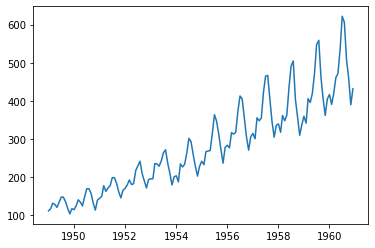

In [2]:
plt.plot(df);

## Stationarity 

**Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the `Test Statistic` is less than the `Critical Value`, we can reject the null hypothesis and say that the series is stationary.

### Stationnarity is required for ARIMA and VAR models.

It's possible to tranform a serie into a stationary one. Common method are:
- Mean substraction
- Differencing
- Decomposing

In [3]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

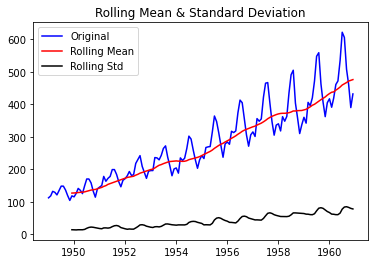

Results of Dickey-Fuller Test:


Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

In [4]:
# The serie is not stationnary
test_stationarity(df)

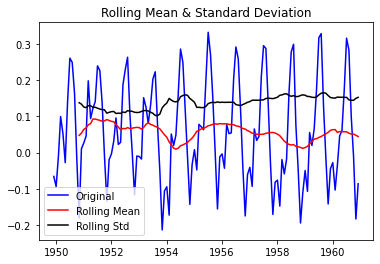

Results of Dickey-Fuller Test:


Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64

In [5]:
# Log
ts_log = np.log(df)
ts_smooth = ts_log.rolling(window = 12).mean()
# Mean substractions
sub_ts = ts_log - ts_smooth
sub_ts.dropna(inplace = True)
test_stationarity(sub_ts)

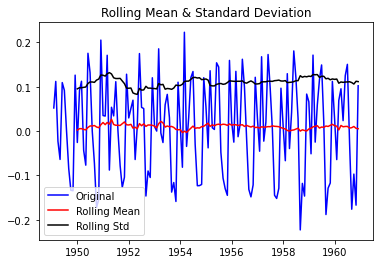

Results of Dickey-Fuller Test:


Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64

In [6]:
# Differencing
ts_diff = ts_log - ts_log.shift()
ts_diff.dropna(inplace = True)
test_stationarity(ts_diff)

# or differencing with exponential weighting
#ts_diff_exp = ts_diff - ts_diff.ewm(halflife = 12).mean()
#ts_diff_exp.dropna(inplace = True)
#test_stationarity(ts_diff_exp)

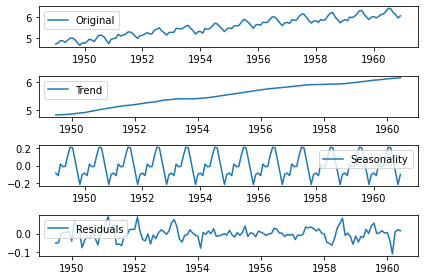

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

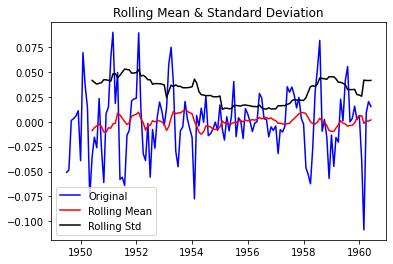

Results of Dickey-Fuller Test:


Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64

In [8]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# ARIMA

ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.


**Selecting p, q, and d values**

1. Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

2. Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

**TL;DR**: Choose AR (p) based on Autocorrelations and MA (q) based on Partial Autocorrelations and I (d) is differenciation (0 or 1)

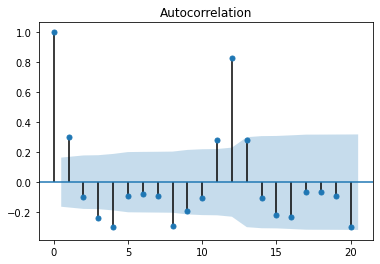

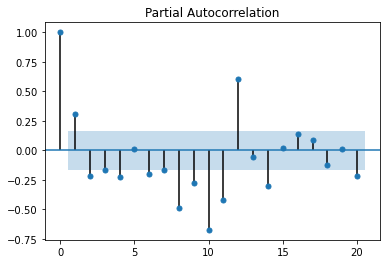

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf((df - df.shift())[1:], lags=20);
plot_pacf((df - df.shift())[1:], lags=20);

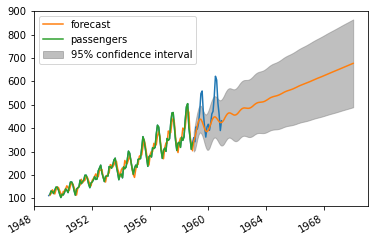

In [10]:
from statsmodels.tsa.arima_model import ARIMA
import warnings

df_train = df.iloc[:-24]
df_test = df.iloc[-24:]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ARIMA model
    model = ARIMA(df_train, order=(2, 1, 2))  
    res = model.fit()

fig, ax = plt.subplots()
ax.plot(df)
res.plot_predict('1949', '1970', ax=ax);

# Modelling with Seasonality

The `SARIMAX` model ([see here](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)) lets you model in exogenous data and cyclic components directly.

For today we'll only see the cyclic component, which is modelled in the `seasonal_order` (p, d, q, S) with seasonality `S`. **NOTE** This first an ARIMA over the cyclic component, so be conservative with cyclic order components.

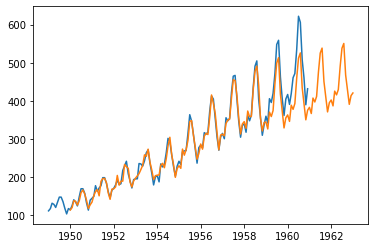

In [11]:
import statsmodels.api as sm

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # SARIMAX model
    mod = sm.tsa.statespace.SARIMAX(
        df_train, order=(2,1,2), seasonal_order=(1,0,0,12))
    res = mod.fit(disp=False)
    #print(res.summary())

fig, ax = plt.subplots()
ax.plot(df)
ax.plot(res.predict('1950', '1963'));

# VAR(p) processes

We are interested in modeling a $T \times K$ multivariate time series
$Y$, where $T$ denotes the number of observations and $K$ the
number of variables. One way of estimating relationships between the time series
and their lagged values is the *vector autoregression process*:

$$
   Y_t = \nu + A_1 Y_{t-1} + \ldots + A_p Y_{t-p} + u_t
$$
$$
   u_t \sim {\sf Normal}(0, \Sigma_u)
$$

where $A_i$ is a $K \times K$ coefficient matrix.

In [12]:
import pandas as pd
pd.options.display.max_rows = 10
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str


mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)

mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)
# IMPORTANT!
data = np.log(mdata).diff().dropna()
data

,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131
1959-12-31,0.003495,0.001084,0.034425
1960-03-31,0.022190,0.009534,0.102664
1960-06-30,-0.004685,0.012572,-0.106694
...,...,...,...
2008-09-30,-0.006781,-0.008948,-0.017836
2008-12-31,-0.013805,-0.007843,-0.069165
2009-03-31,-0.016612,0.001511,-0.175598
2009-06-30,-0.001851,-0.002196,-0.067561


In [13]:
model = VAR(data)
results = model.fit(2)
results.summary()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, May, 2021
Time:                     20:16:28
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

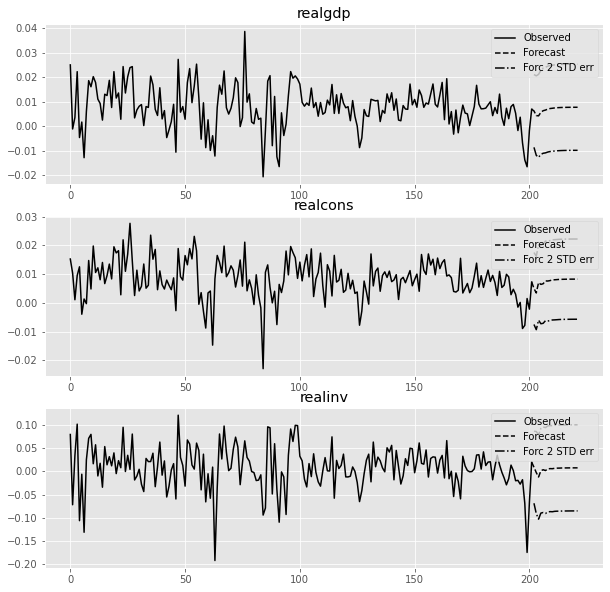

In [14]:
#model.select_order(15)
results = model.fit(maxlags=15, ic='aic')
results.plot_forecast(20);

# Impulse Response

Impulse responses are of interest in econometric studies: they are the estimated responses to a unit impulse in one of the variables:

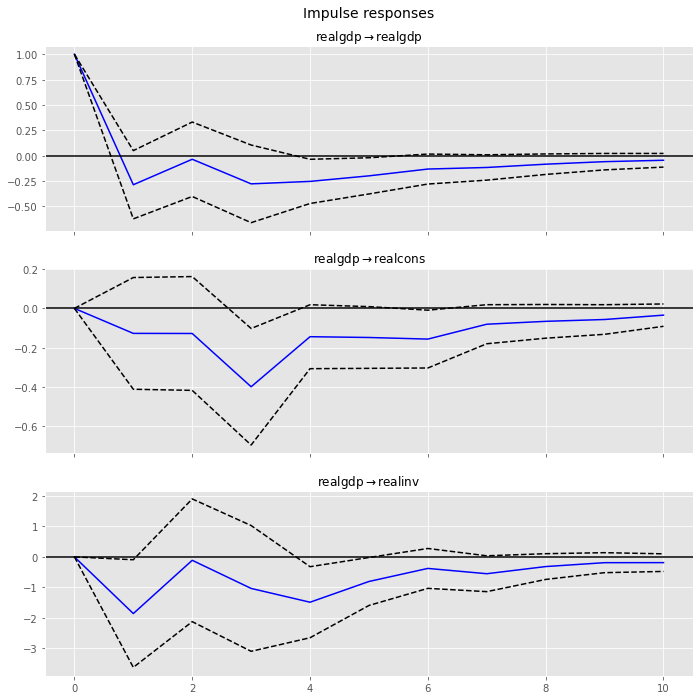

In [15]:
irf = results.irf(10)
irf.plot(impulse='realgdp');

# Granger causality

You may be interested in whether a variable or group of variables is “causal” for another variable.

In the context of VAR models, one can say that a set of variables are **Granger-Causal** within one of the VAR equations. [Granger Causality](https://en.wikipedia.org/wiki/Granger_causality) assumes that:

1. The cause happens prior to its effect.

2. The cause has unique information about the future values of its effect.

So if the lagged value in a series are uniquely identified to cause correlated movement in the future of another, we can say that it "Granger Causes" the movement.

In [16]:
results.test_causality('realgdp', ['realinv', 'realcons'], kind='f').summary()

Test statistic,Critical value,p-value,df
7.000,2.115,0.000,"(6, 567)"


# Panel Data

A **Panel** dataset is a dataset that incorporates both a time index and an "entity" index. For instance, imagine a study following students through their high school years. A unit of observation in this case would be a student/year combination.

In [17]:
# !pip install linearmodels
from linearmodels.datasets import wage_panel
import pandas as pd

data = wage_panel.load()
year = pd.Categorical(data.year)
data = data.set_index(["nr", "year"])
data["year"] = year
print(wage_panel.DESCR)
data.sample(5)


F. Vella and M. Verbeek (1998), "Whose Wages Do Unions Raise? A Dynamic Model
of Unionism and Wage Rate Determination for Young Men," Journal of Applied
Econometrics 13, 163-183.

nr                       person identifier
year                     1980 to 1987
black                    =1 if black
exper                    labor market experience
hisp                     =1 if Hispanic
hours                    annual hours worked
married                  =1 if married
educ                     years of schooling
union                    =1 if in union
lwage                    log(wage)
expersq                  exper^2
occupation               Occupation code



,,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation,year
nr,year,,,,,,,,,,,
3591,1984,0,6,0,2136,1,12,1,2.032702,36,7,1984
9132,1987,0,14,0,2080,1,6,1,1.861079,196,5,1987
2741,1982,0,7,0,2080,1,12,0,1.285038,49,6,1982
6186,1983,1,5,0,2080,1,12,0,1.725410,25,5,1983
3414,1984,0,5,0,1965,0,16,0,1.873734,25,5,1984


## Basic regression on panel data

The simplest way to deal with panel data is to ignore it. Pooled Models simply work like a normal (cross section) model including a dummy variable for each $t$ time section.

In `linearmodels` we have ``PooledOLS`` is just plain OLS that understands that various panel data structures. It is useful as a base model. Here the log wage is modeled using all of the variables and time dummies.

In [18]:
from linearmodels.panel import PooledOLS
import statsmodels.api as sm

exog_vars = ["black", "hisp", "exper", "expersq", "married", "educ", "union", "year"]
exog = sm.add_constant(data[exog_vars])
mod = PooledOLS(data.lwage, exog)
pooled_res = mod.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                        0.1893
Estimator:                  PooledOLS   R-squared (Between):              0.2066
No. Observations:                4360   R-squared (Within):               0.1692
Date:                Sun, May 02 2021   R-squared (Overall):              0.1893
Time:                        20:16:34   Log-likelihood                   -2982.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      72.459
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(14,4345)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             72.459
                            